In [1]:
# Importing all the necessary libraries needed throughout the study
import warnings
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.preprocessing import ICA
import scipy .io
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import GridSearchCV

In [2]:
# Closing the warnings
warnings.filterwarnings("ignore")

In [4]:
# Preprocessing EEG train datasets of 9 subjects (stored in different gdf files) by removing EOG artifacts with ICA,
# filtering mental processes, segmenting these mental processes into 1-second long windows,
# extracting band power features for each segment and channel, labeling the segments for classification tasks later  
def process_train_data(file_path):
    # Reading the train files
    train = mne.io.read_raw_gdf(file_path, eog = ["EOG-left", "EOG-central", "EOG-right"], preload=True)
    # bandpass filtering (0.1 HZ - 100 Hz)
    train.filter(l_freq=0.1, h_freq=100)
    # applying ICA to decompose EOG from EEG signals
    ica = ICA(n_components=22)
    ica.fit(train)
    eog_indices, scores = ica.find_bads_eog(train, ch_name=['EOG-left', 'EOG-central', 'EOG-right'])
    ica.exclude = eog_indices
    train_clean = ica.apply(train)
    # Picking just the eeg part, not the eog part
    eeg_data = train_clean.pick_types(eeg=True, eog=False)
    # As eeg_data contains two numpy arrays, the first one contains the eeg values and the second one contains the time values
    eeg_values, times = eeg_data[:]
    # The shape of the eeg values is 22 x 672526, since there are 22 channels, the array should be transpozed to see the channels on the columns
    # The columns should be defined to make the dataframe clear to understand, so the channel names of the eeg data are taken and set as columns
    eeg_train = pd.DataFrame(eeg_values.T, columns = eeg_data.info['ch_names'])

    # Extracting the events of the train datasets
    # events_train is an array that contains 3 columns, involving information about the starting sample point of the event in the first column and which event defined in the third column
    events_train, event_id = mne.events_from_annotations(train)
    starting_sample = events_train[:, 0]
    # Taking the starting sample points of the events which are 769 (left class cue), 770 (right class cue), 771 (foot class cue), 772 (tongue class cue)
    left_train = starting_sample[events_train[:, 2] == event_id["769"]]
    right_train = starting_sample[events_train[:, 2] == event_id["770"]]
    foot_train = starting_sample[events_train[:, 2] == event_id["771"]]
    tongue_train = starting_sample[events_train[:, 2] == event_id["772"]]

    # Extracting the parts where the mental processes happen for each class and then segmenting the mental processes into 1 second long
    # Mental processes start 1 second after the start of the cue event and last for a total of 3 seconds
    # Segmenting the mental processes (3 seconds) into 1 second long (so, 1 trial takes 3 seconds)
    # Since there are 288 trials (72 for each class), 288 * 3 = 864 segments at the end!
    def segment_data(events, class_name):
        segments = []
        segment_no = 1
        for start in events:
            start_sample = start + 250
            end_sample = start_sample + 750
            for segment in range(start_sample, end_sample - 249, 250):
                segment_data = eeg_train.iloc[segment:segment + 250]
                segment_data['Segment'] = f"{class_name}_segment_{segment_no}"
                segments.append(segment_data)
                segment_no += 1
        return pd.concat(segments, ignore_index=True)
    left_train_df = segment_data(left_train, "left")
    right_train_df = segment_data(right_train, "right")
    foot_train_df = segment_data(foot_train, "foot")
    tongue_train_df = segment_data(tongue_train, "tongue")
    train_dataset = pd.concat([left_train_df, right_train_df, foot_train_df, tongue_train_df], ignore_index=True)

    # Band power calculation for each segment and each channel
    def band_power(data):
        frequency_bands = {
            'DELTA': [0.5, 3.5],
            'THETA': [4, 7],
            'ALPHA': [8, 13],
            'BETA': [13, 25],
            'GAMMA': [25, 48]
        }
        fs = 250
        results = {}
        for column in data.columns:
            x = data[column].values
            frequencies, psd = signal.welch(x, fs, nperseg=1024)
            for band, freqrange in frequency_bands.items():
                freq_indices = np.where((frequencies >= freqrange[0]) & (frequencies <= freqrange[1]))
                p = np.trapz(psd[freq_indices], frequencies[freq_indices])
                results[f"{band}_{column}"] = p
        return pd.DataFrame([results])
    
    segment_band_powers = []
    for segment in train_dataset['Segment'].unique():
        segment_data = train_dataset[train_dataset['Segment'] == segment].drop(columns=['Segment'])
        band_powers = band_power(segment_data)
        band_powers['Segment'] = segment
        segment_band_powers.append(band_powers)
    train_dataset_final = pd.concat(segment_band_powers, ignore_index=True)
    # Labeling each segment as 1 for left hand, 2 for right hand, 3 for foot, 4 for tongue class
    train_dataset_final['Label'] = train_dataset_final['Segment'].map(
        lambda x: 1 if 'left' in x.lower() else
                  2 if 'right' in x.lower() else
                  3 if 'foot' in x.lower() else
                  4
    )
    train_dataset_final = train_dataset_final.drop(columns="Segment")
    return train_dataset_final

# The function is run for all train files (9 train files)
train_files = ['A01T.gdf', 'A02T.gdf', 'A03T.gdf', 'A04T.gdf', 'A05T.gdf', 'A06T.gdf', 'A07T.gdf', 'A08T.gdf', 'A09T.gdf']

results_train = []
for train_file in train_files:
    result = process_train_data(train_file)
    results_train.append(result)
print(results_train)

[     DELTA_EEG-Fz  THETA_EEG-Fz  ALPHA_EEG-Fz   BETA_EEG-Fz  GAMMA_EEG-Fz  \
0    5.848628e-12  5.431944e-12  1.296154e-11  5.862060e-12  2.831447e-12   
1    5.608636e-12  1.220371e-11  9.436763e-12  9.893121e-12  2.809614e-12   
2    5.835124e-12  4.670791e-12  4.174360e-12  5.146797e-12  2.242303e-12   
3    1.341768e-12  1.391480e-11  2.018454e-12  4.042639e-12  2.583272e-12   
4    1.124085e-12  4.371427e-12  1.137868e-11  4.509079e-12  3.416033e-12   
..            ...           ...           ...           ...           ...   
859  6.603354e-12  6.543760e-12  8.233228e-12  1.036676e-11  3.166058e-12   
860  2.208663e-11  1.590001e-12  1.078474e-11  3.373852e-12  2.665006e-12   
861  2.657016e-11  4.881882e-12  2.673835e-11  9.387166e-12  6.388732e-12   
862  2.729765e-12  1.462300e-11  1.070778e-11  5.147811e-12  3.478667e-12   
863  6.789691e-12  2.269732e-11  1.109083e-11  6.979971e-12  4.168014e-12   

      DELTA_EEG-0   THETA_EEG-0   ALPHA_EEG-0    BETA_EEG-0   GAMMA_EEG-0 

In [10]:
# Preprocessing EEG test datasets of 9 subjects (stored in different gdf files) by removing EOG artifacts with ICA,
# filtering mental processes, segmenting these mental processes into 1-second long windows,
# extracting band power features for each segment and channel, labeling the segments for classification tasks later by using true labels matlab files for each subject 
def process_test_data(test_file, label_file):
    # Reading test files
    # The same with train part
    test = mne.io.read_raw_gdf(test_file, eog = ["EOG-left", "EOG-central", "EOG-right"], preload=True)
    # bandpass filtering (0.1 HZ - 100 Hz)
    test.filter(l_freq=0.1, h_freq=100)
    # applying ICA to decompose EOG from EEG signals
    ica = ICA(n_components=22)
    ica.fit(test)
    eog_indices, scores = ica.find_bads_eog(test, ch_name=['EOG-left', 'EOG-central', 'EOG-right'])
    ica.exclude = eog_indices
    test_clean = ica.apply(test)
    # Picking just the eeg part, not the eog part
    eeg_data = test_clean.pick_types(eeg=True, eog=False)
    # As eeg_data contains two numpy arrays, the first one contains the eeg values and the second one contains the time values
    eeg_values, times = eeg_data[:]
    # The shape of the eeg values is 22 x 672526, since there are 22 channels, the array should be transpozed to see the channels on the columns
    # The columns should be defined to make the dataframe clear to understand, so the channel names of the eeg data are taken and set as columns
    eeg_test = pd.DataFrame(eeg_values.T, columns = eeg_data.info['ch_names'])
    
    # Extracting the events
    # Since left cue, right cue, foot cue and tongue cue are not available in test files, the unknown cue is taken into consideration (event id = 783)
    events_test, event_id = mne.events_from_annotations(test)
    starting_sample = events_test[:,0]
    unknown = starting_sample[events_test[:,2] == event_id["783"]]
    
    # True labels are extracted from the files to check which class the unknown cue belongs to 
    labels = scipy.io.loadmat(label_file)
    labels = labels['classlabel'].flatten()
    
    # The mental processes start 1 second after the unknown cue starts and takes 3 seconds in total
    # Trial column is added to the result to see which class is active on that trial by the labels files (1 trial = 3 seconds, there are 288 trials defined in the description)
    unknown_test_segments = []
    trial_no = 1
    for i in range(len(unknown)):
        unknown_test_start = unknown[i] + 250
        unknown_test_end = unknown_test_start + 750
        unknown_test_data = eeg_test.iloc[unknown_test_start:unknown_test_end]
        unknown_test_data['Trial'] = trial_no
        unknown_test_segments.append(unknown_test_data)
        trial_no += 1
    test_dataset = pd.concat(unknown_test_segments, ignore_index=True)
    # Since there are 288 trials and the length of the labels datasets is 288, the labels of each trials are defined in the labels datasets
    # The labels are given to the trials respectively
    test_dataset['Label'] = test_dataset['Trial'].apply(lambda x: labels[x-1])
    # 1 Trial = 3 seconds = 3 segments = 750 entries
    # 1 segment = 250 entries
    # 1 Trial will be divided into three segments as 250, 250, 250
    test_dataset['Segment'] = (test_dataset.index // 250) + 1

    # Band power calculation for each segment and each channel
    def band_power(data):
        frequency_bands = {
            'DELTA': [0.5, 3.5],
            'THETA': [4, 7],
            'ALPHA': [8, 13],
            'BETA': [13, 25],
            'GAMMA': [25, 48]
        }
        fs = 250
        results = {}
        for column in data.columns:
            x = data[column].values
            frequencies, psd = signal.welch(x, fs, nperseg=1024)
            for band, freqrange in frequency_bands.items():
                freq_indices = np.where((frequencies >= freqrange[0]) & (frequencies <= freqrange[1]))
                p = np.trapz(psd[freq_indices], frequencies[freq_indices])
                results[f"{band}_{column}"] = p
        return pd.DataFrame([results])
    
    segment_band_powers = []
    for segment in test_dataset['Segment'].unique():
        segment_data = test_dataset[test_dataset['Segment'] == segment].drop(columns=['Segment', "Trial", "Label"])
        band_powers = band_power(segment_data)
        band_powers["Label"] = test_dataset[test_dataset['Segment'] == segment]['Label'].iloc[0]
        segment_band_powers.append(band_powers)
    test_dataset_final = pd.concat(segment_band_powers, ignore_index=True)
    return test_dataset_final

# The function is run for all test files (9 test files)
test_files = ['A01E.gdf', 'A02E.gdf', 'A03E.gdf', 'A04E.gdf', 'A05E.gdf', 'A06E.gdf', 'A07E.gdf', 'A08E.gdf', 'A09E.gdf']
label_files = ['A01E.mat', 'A02E.mat', 'A03E.mat', 'A04E.mat', 'A05E.mat', 'A06E.mat', 'A07E.mat', 'A08E.mat', 'A09E.mat']

results_test = []
for test_file, label_file in zip(test_files, label_files):
    result = process_test_data(test_file, label_file)
    results_test.append(result)
print(results_test)

[     DELTA_EEG-Fz  THETA_EEG-Fz  ALPHA_EEG-Fz   BETA_EEG-Fz  GAMMA_EEG-Fz  \
0    6.965128e-12  4.865378e-12  6.501094e-12  4.784798e-12  3.341501e-12   
1    2.490085e-11  5.217065e-12  1.803819e-11  8.273293e-12  2.034203e-12   
2    3.324845e-11  9.887993e-12  2.551978e-11  6.987246e-12  1.898956e-12   
3    1.259280e-11  7.379413e-12  7.345057e-12  1.113770e-11  2.073968e-12   
4    1.059973e-11  1.339920e-11  2.751497e-12  4.790686e-12  2.605749e-12   
..            ...           ...           ...           ...           ...   
859  2.386976e-12  3.182369e-12  5.796388e-12  6.918727e-12  3.573467e-12   
860  7.482992e-12  4.179701e-12  5.832087e-12  2.832079e-12  2.422679e-12   
861  1.566729e-11  1.415793e-11  4.602856e-12  1.061915e-11  3.384109e-12   
862  1.216107e-11  1.487488e-11  9.206553e-12  1.174562e-11  3.945367e-12   
863  2.355825e-11  1.900966e-11  5.351747e-12  1.012740e-11  4.485012e-12   

      DELTA_EEG-0   THETA_EEG-0   ALPHA_EEG-0    BETA_EEG-0   GAMMA_EEG-0 

In [60]:
# Evaluating the accuracies of the classifiers after splitting the preprocessed train and test datasets based on the band power and class pairs
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(results_train)):
    subject_id = i + 1
    for band_power in ['ALPHA', 'BETA', 'DELTA', 'THETA', 'GAMMA']:
        for class_pair in [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]:
            y_train = results_train[i].loc[results_train[i]["Label"].isin(class_pair), "Label"]
            X_train = results_train[i].loc[results_train[i].index.isin(y_train.index), results_train[i].columns.str.contains(band_power)]
            y_test = results_test[i].loc[results_test[i]["Label"].isin(class_pair), "Label"]
            X_test = results_test[i].loc[results_test[i].index.isin(y_test.index), results_test[i].columns.str.contains(band_power)]

            for model_name, model in models.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                accuracies.append({
                    "Subject ID": subject_id,
                    "Class Pair": class_pair,
                    "Band Power": band_power,
                    "Model": model_name,
                    "Accuracy": accuracy
                })

accuracy_without_c_optimization_and_feature_selection = pd.DataFrame(accuracies)
accuracy_without_c_optimization_and_feature_selection

,Subject ID,Class Pair,Band Power,Model,Accuracy
0,1,"[1, 2]",ALPHA,Logistic Regression,0.500000
1,1,"[1, 2]",ALPHA,Decision Tree,0.500000
2,1,"[1, 2]",ALPHA,Random Forest,0.500000
3,1,"[1, 2]",ALPHA,SVC,0.574074
4,1,"[1, 2]",ALPHA,KNN,0.527778
...,...,...,...,...,...
1615,9,"[3, 4]",GAMMA,Decision Tree,0.500000
1616,9,"[3, 4]",GAMMA,Random Forest,0.500000
1617,9,"[3, 4]",GAMMA,SVC,0.583333
1618,9,"[3, 4]",GAMMA,KNN,0.532407


In [137]:
# Evaluating accuracies with c optimization
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(results_train)):
    subject_id = i + 1
    for band_power in ['ALPHA', 'BETA', 'DELTA', 'THETA', 'GAMMA']:
        for class_pair in [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]:
            y_train = results_train[i].loc[results_train[i]["Label"].isin(class_pair), "Label"]
            X_train = results_train[i].loc[results_train[i].index.isin(y_train.index), results_train[i].columns.str.contains(band_power)]
            y_test = results_test[i].loc[results_test[i]["Label"].isin(class_pair), "Label"]
            X_test = results_test[i].loc[results_test[i].index.isin(y_test.index), results_test[i].columns.str.contains(band_power)]

            for model_name, model in models.items():
                if model_name == "SVC":
                    param_grid = {'C': [0.1, 1, 10, 100, 1000]}
                    grid_search = GridSearchCV(SVC(), param_grid, cv=2)
                    grid_search.fit(X_train, y_train)
                    best_model = grid_search.best_estimator_
                    y_pred = best_model.predict(X_test)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                accuracies.append({
                    "Subject ID": subject_id,
                    "Band Power": band_power,
                    "Class Pair": class_pair,
                    "Model": model_name,
                    "Accuracy": accuracy
                })

accuracy_with_c_optimization = pd.DataFrame(accuracies)
accuracy_with_c_optimization

,Subject ID,Band Power,Class Pair,Model,Accuracy
0,1,ALPHA,"[1, 2]",Logistic Regression,0.500000
1,1,ALPHA,"[1, 2]",Decision Tree,0.500000
2,1,ALPHA,"[1, 2]",Random Forest,0.500000
3,1,ALPHA,"[1, 2]",SVC,0.567130
4,1,ALPHA,"[1, 2]",KNN,0.527778
...,...,...,...,...,...
1615,9,GAMMA,"[3, 4]",Decision Tree,0.500000
1616,9,GAMMA,"[3, 4]",Random Forest,0.500000
1617,9,GAMMA,"[3, 4]",SVC,0.567130
1618,9,GAMMA,"[3, 4]",KNN,0.532407


In [85]:
# Evaluating accuracies with kbest - anova
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(results_train)):
    subject_id = i + 1
    for band_power in ['ALPHA', 'BETA', 'DELTA', 'THETA', 'GAMMA']:
        for class_pair in [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]:
            y_train = results_train[i].loc[results_train[i]["Label"].isin(class_pair), "Label"]
            X_train = results_train[i].loc[results_train[i].index.isin(y_train.index), results_train[i].columns.str.contains(band_power)]
            y_test = results_test[i].loc[results_test[i]["Label"].isin(class_pair), "Label"]
            X_test = results_test[i].loc[results_test[i].index.isin(y_test.index), results_test[i].columns.str.contains(band_power)]

            for model_name, model in models.items():
                best_accuracy = 0
                best_k = 0

                for k in range(1, X_train.shape[1] + 1):
                    kbest = SelectKBest(f_classif, k=k)
                    X_train_kbest = kbest.fit_transform(X_train, y_train)
                    X_test_kbest = kbest.transform(X_test)

                    model.fit(X_train_kbest, y_train)
                    y_pred = model.predict(X_test_kbest)
                    accuracy = accuracy_score(y_test, y_pred)

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_k = k

                accuracies.append({
                    "Subject ID": subject_id,
                    "Band Power": band_power,
                    "Class Pair": class_pair,
                    "Model": model_name + " - kbest - anova",
                    "Best k": best_k,
                    "Accuracy": best_accuracy
                })

accuracies_with_kbest_anova = pd.DataFrame(accuracies)
accuracies_with_kbest_anova

,Subject ID,Band Power,Class Pair,Model,Best k,Accuracy
0,1,ALPHA,"[1, 2]",Logistic Regression - kbest - anova,1,0.500000
1,1,ALPHA,"[1, 2]",Decision Tree - kbest - anova,1,0.500000
2,1,ALPHA,"[1, 2]",Random Forest - kbest - anova,1,0.500000
3,1,ALPHA,"[1, 2]",SVC - kbest - anova,7,0.615741
4,1,ALPHA,"[1, 2]",KNN - kbest - anova,6,0.594907
...,...,...,...,...,...,...
1615,9,GAMMA,"[3, 4]",Decision Tree - kbest - anova,1,0.500000
1616,9,GAMMA,"[3, 4]",Random Forest - kbest - anova,1,0.500000
1617,9,GAMMA,"[3, 4]",SVC - kbest - anova,17,0.599537
1618,9,GAMMA,"[3, 4]",KNN - kbest - anova,19,0.569444


In [98]:
# Evaluating accuracies with kbest - chi2
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(results_train)):
    subject_id = i + 1
    for band_power in ['ALPHA', 'BETA', 'DELTA', 'THETA', 'GAMMA']:
        for class_pair in [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]:
            y_train = results_train[i].loc[results_train[i]["Label"].isin(class_pair), "Label"]
            X_train = results_train[i].loc[results_train[i].index.isin(y_train.index), results_train[i].columns.str.contains(band_power)]
            y_test = results_test[i].loc[results_test[i]["Label"].isin(class_pair), "Label"]
            X_test = results_test[i].loc[results_test[i].index.isin(y_test.index), results_test[i].columns.str.contains(band_power)]

            for model_name, model in models.items():
                best_accuracy = 0
                best_k = 0

                for k in range(1, X_train.shape[1] + 1):
                    kbest = SelectKBest(chi2, k=k)
                    X_train_kbest = kbest.fit_transform(X_train, y_train)
                    X_test_kbest = kbest.transform(X_test)

                    model.fit(X_train_kbest, y_train)
                    y_pred = model.predict(X_test_kbest)
                    accuracy = accuracy_score(y_test, y_pred)

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_k = k

                accuracies.append({
                    "Subject ID": subject_id,
                    "Band Power": band_power,
                    "Class Pair": class_pair,
                    "Model": model_name + " - kbest - chi2",
                    "Best k": best_k,
                    "Accuracy": best_accuracy
                })

accuracies_with_kbest_chi2 = pd.DataFrame(accuracies)
accuracies_with_kbest_chi2

,Subject ID,Band Power,Class Pair,Model,Best k,Accuracy
0,1,ALPHA,"[1, 2]",Logistic Regression - kbest - chi2,1,0.500000
1,1,ALPHA,"[1, 2]",Decision Tree - kbest - chi2,1,0.500000
2,1,ALPHA,"[1, 2]",Random Forest - kbest - chi2,1,0.500000
3,1,ALPHA,"[1, 2]",SVC - kbest - chi2,3,0.592593
4,1,ALPHA,"[1, 2]",KNN - kbest - chi2,5,0.594907
...,...,...,...,...,...,...
1615,9,GAMMA,"[3, 4]",Decision Tree - kbest - chi2,1,0.500000
1616,9,GAMMA,"[3, 4]",Random Forest - kbest - chi2,1,0.500000
1617,9,GAMMA,"[3, 4]",SVC - kbest - chi2,4,0.594907
1618,9,GAMMA,"[3, 4]",KNN - kbest - chi2,4,0.571759


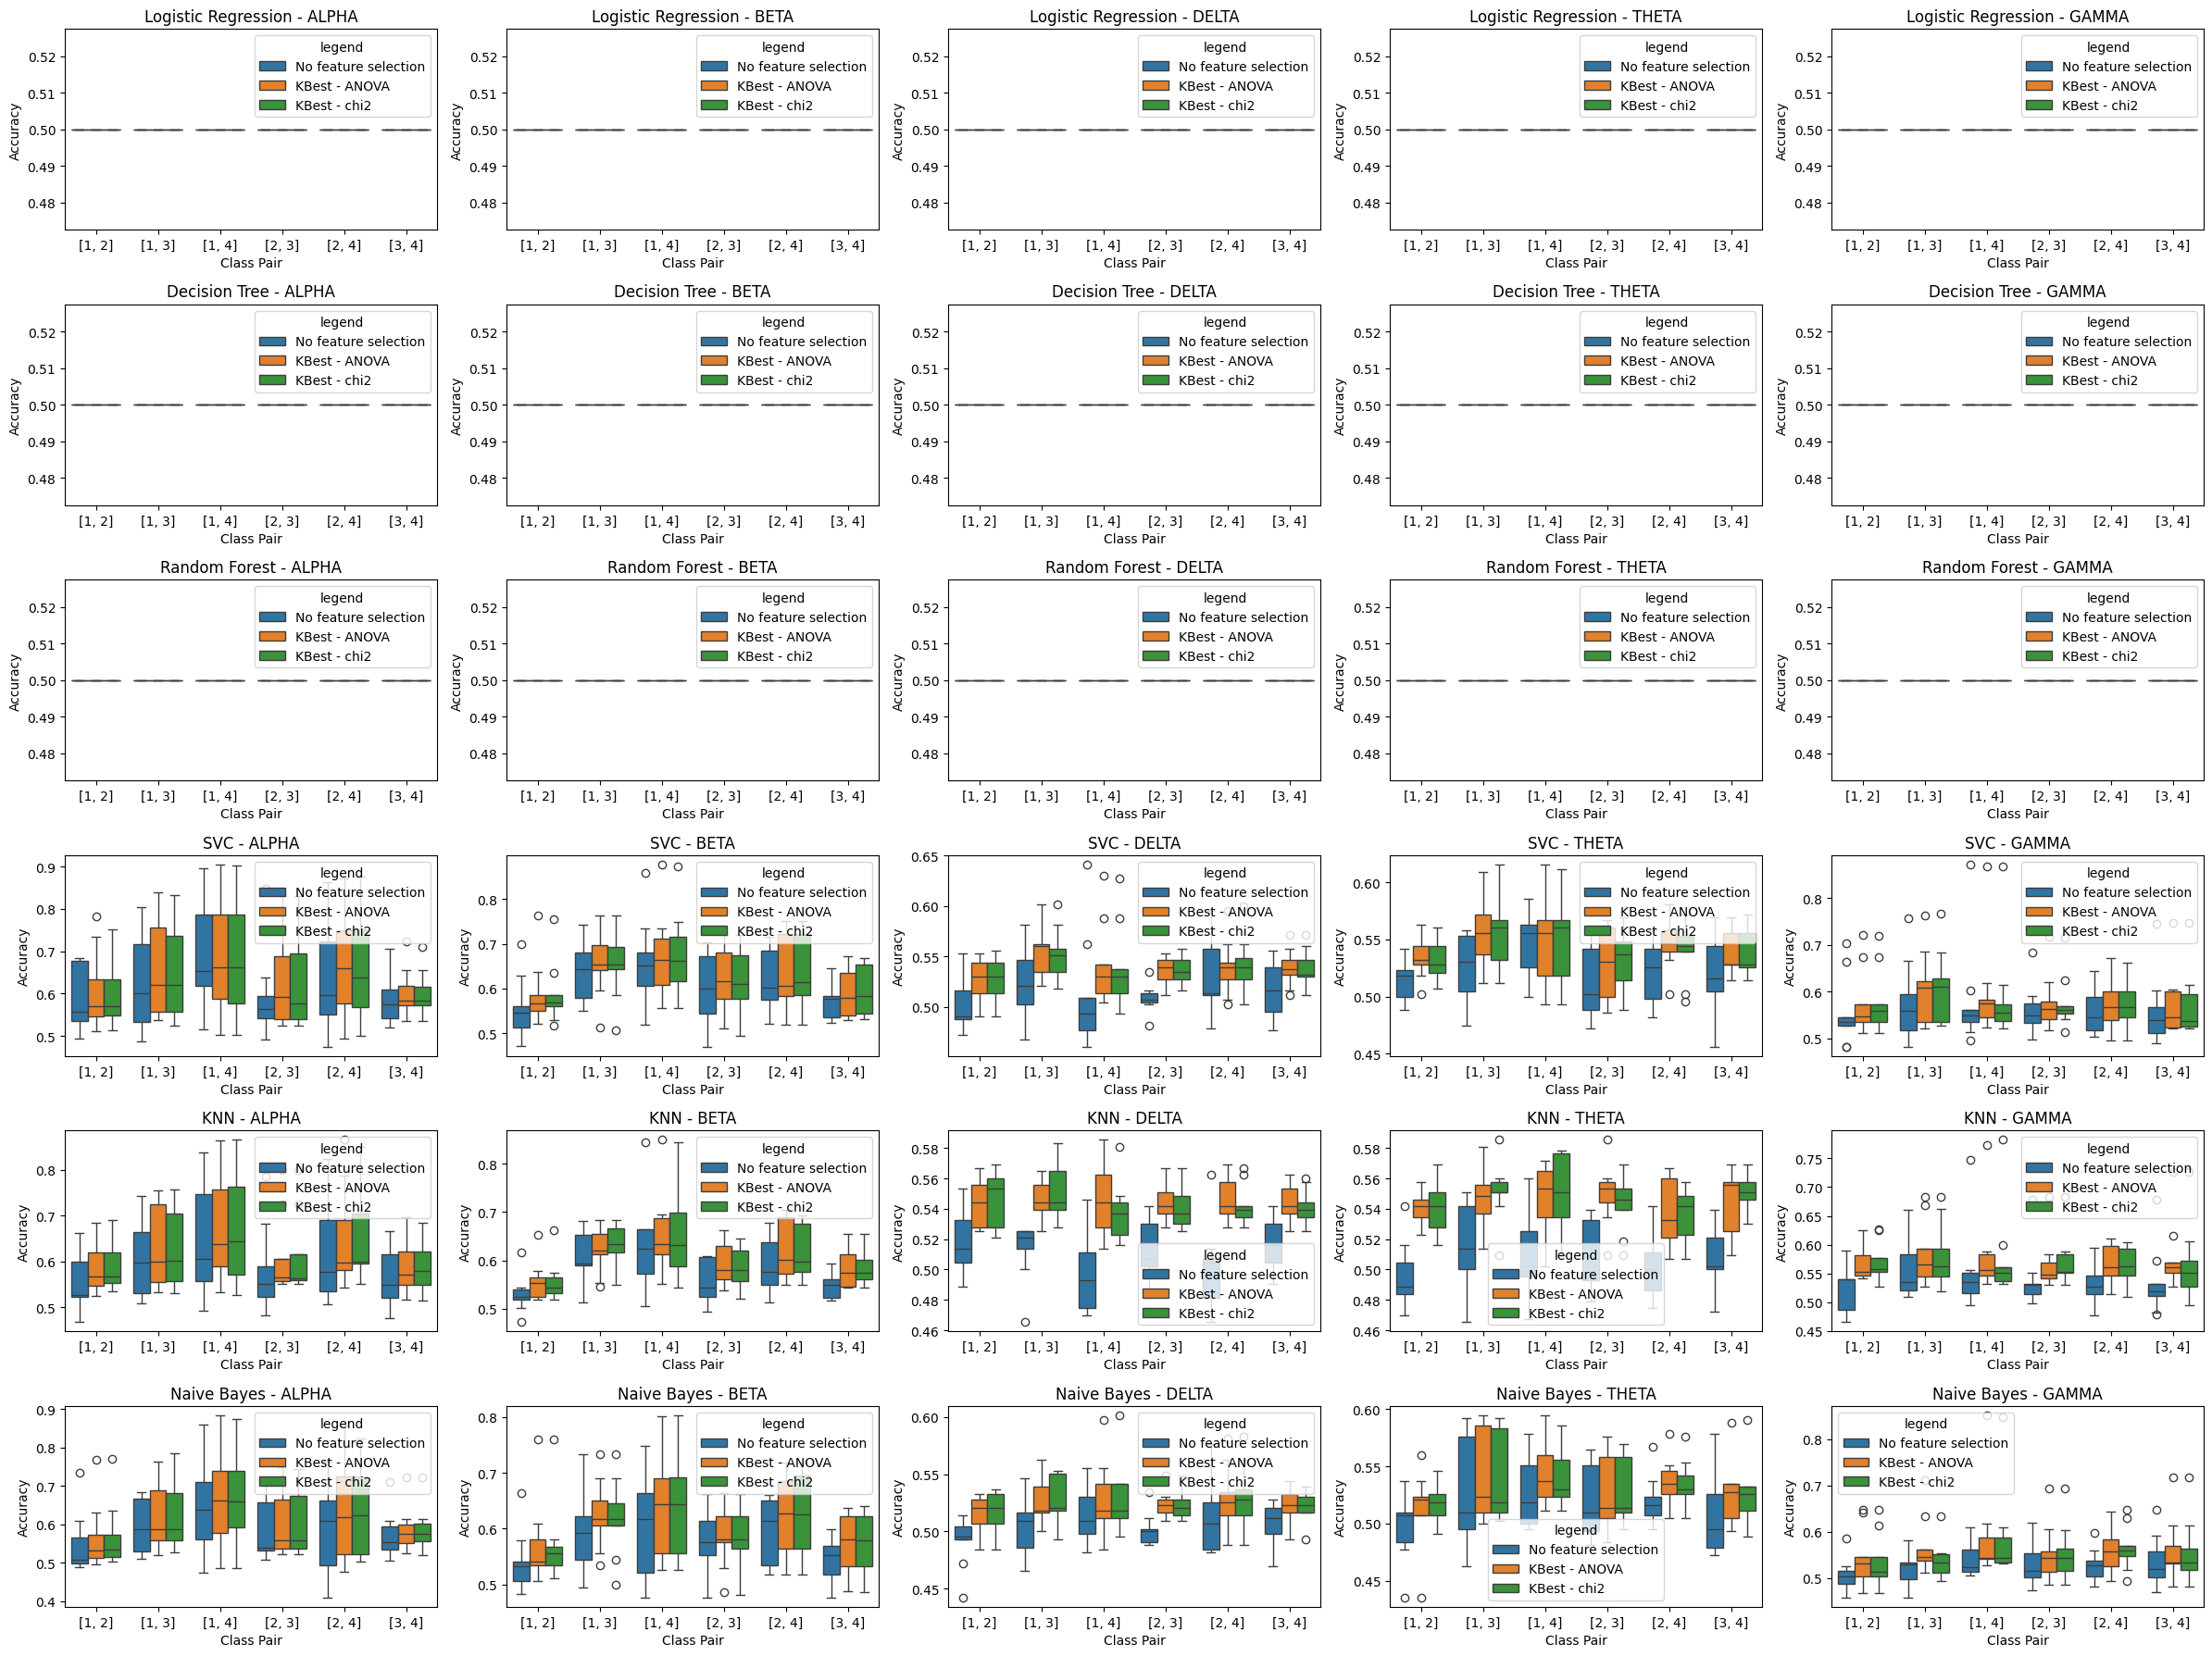

In [ ]:
# Visualization of the accuracies to compare the feature selection methods
all_accuracies = pd.concat([accuracy_with_c_optimization, accuracies_with_kbest_anova.drop(columns="Best k"), accuracies_with_kbest_chi2.drop(columns="Best k")], axis=0)
all_accuracies["legend"] = all_accuracies["Model"].apply(lambda x: "KBest - ANOVA" if "anova" in x else ("KBest - chi2" if "chi2" in x else "No feature selection"))

band_powers = ["ALPHA", "BETA", "DELTA", "THETA", "GAMMA"]
models = ["Logistic Regression", "Decision Tree", "Random Forest", "SVC", "KNN", "Naive Bayes"]

fig, axes = plt.subplots(6, 5, figsize=(24, 18))
axes = axes.flatten()

subplot_id = 0
for model in models:
    classifier_result = all_accuracies[all_accuracies["Model"].str.contains(model)]
    for band_power in band_powers:
        ax = axes[subplot_id]
        subset = classifier_result[classifier_result["Band Power"] == band_power]
        
        sns.boxplot(x="Class Pair", y="Accuracy", hue="legend", data=subset, ax=ax)

        ax.set_title(f"{model} - {band_power}")
        ax.set_xlabel("Class Pair")
        ax.set_ylabel("Accuracy")

        subplot_id += 1

plt.tight_layout()
plt.show()